# Binding energy

Source of the original code: https://scipython.com/blog/nuclear-binding-energies-1/ 

The <b>binding energy</b> of a nucleus is the energy that would be required to split apart each of its constituent protons and neutrons (nucleons). This energy is due to the forces that hold the nucleus together, which may be thought of as a balance between the attractive strong nuclear force and the electromagnetic force (which is repulsive between the positively-charged protons). The binding energy manifests itself in a mass difference between the nucleus and the individual nucleons ($E=mc^2$) and the difference in binding energy between different nuclei is the energy released in the process of nuclear fusion and fission.

In nuclear physics, the <b>semi-empirical mass formula (SEMF)</b> (sometimes also called the Weizsäcker formula, Bethe–Weizsäcker formula, or Bethe–Weizsäcker mass formula to distinguish it from the Bethe–Weizsäcker process) is used to approximate the mass of an atomic nucleus from its number of protons and neutrons. As the name suggests, it is based partly on theory and partly on empirical measurements. The formula represents the liquid-drop model proposed by George Gamow, which can account for most of the terms in the formula and gives rough estimates for the values of the coefficients. It was first formulated in 1935 by German physicist Carl Friedrich von Weizsäcker, and although refinements have been made to the coefficients over the years, the structure of the formula remains the same today.

The formula gives a good approximation for atomic masses and thereby other effects. However, it fails to explain the existence of lines of greater binding energy at certain numbers of protons and neutrons. These numbers, known as magic numbers, are the foundation of the nuclear shell model.

https://en.wikipedia.org/wiki/Semi-empirical_mass_formula

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def SEMF(Z, N):
    """Calculate the average binding energy per nucleon for nucleus Z, N.

    Calculate the average nuclear binding energy per nucleon for a nucleus
    with Z protons and N neutrons, using the semi-empirical mass formula and
    parameters of J. W. Rohlf, "Modern Physics from alpha to Z0", Wiley (1994).

    Z and N can be NumPy arrays or scalar values.

    """

    # The parameterization of the SEMF to use.
    aV, aS, aC, aA, delta = 15.75, 17.8, 0.711, 23.7, 11.18

    # Covert Z and N to NumPy arrays if they aren't already
    Z, N = np.atleast_1d(Z), np.atleast_1d(N)
    # Total number of nucleons
    A = Z + N

    # The pairing term is -delta for Z and N both odd, +delta for Z and N both
    # even, and 0 otherwise. Create an array of the sign of this term so that
    # we can vectorize the calculation across the arrays Z and N.
    sgn = np.zeros(Z.shape)
    sgn[(Z%2) & (N%2)] = -1
    sgn[~(Z%2) & ~(N%2)] = +1

    # The SEMF for the average binding energy per nucleon.
    E = (aV - aS / A**(1/3) - aC * Z**2 / A**(4/3) -
         aA * (A-2*Z)**2/A**2 + sgn * delta/A**(3/2))

    # Return E as a scalar or array as appropriate to the input Z.
    if Z.shape[0] == 1:
        return float(E)
    return E

In [4]:
# Read the experimental data into a Pandas DataFrame.
df = pd.read_fwf('mass.mas03', usecols=(2,3,4,11),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              skiprows=39, header=None,
              index_col=False)
df.columns = ('N', 'Z', 'A', 'avEbind')

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the avEbind column won't be numeric. Coerce to float and drop these entries.
df['avEbind'] = pd.to_numeric(df['avEbind'], errors='coerce')
df = df.dropna()
# Also convert from keV to MeV.
df['avEbind'] /= 1000

# Group the DataFrame by nucleon number, A.
gdf = df.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
maxavEbind = gdf.apply(lambda t: t[t.avEbind==t.avEbind.max()])

# Add a column of estimated binding energies calculated using the SEMF.
maxavEbind['Eapprox'] = SEMF(maxavEbind['Z'], maxavEbind['N'])



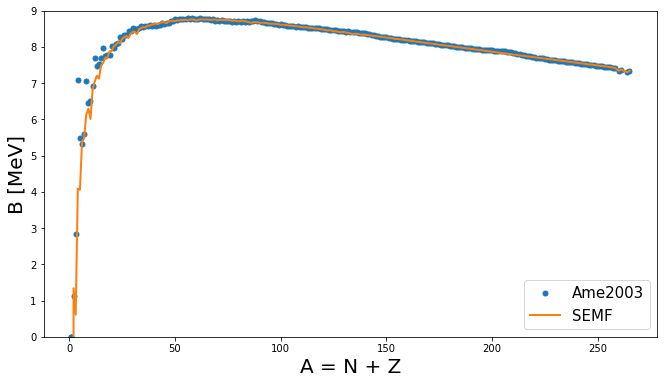

In [28]:
# Generate a plot comparing the experimental with the SEMF values.

fig, ax = plt.subplots(figsize=(11,6))
ax.plot(maxavEbind['A'], maxavEbind['avEbind'], marker='.', markersize=10, linestyle='', label='Ame2003')
ax.plot(maxavEbind['A'], maxavEbind['Eapprox'], lw=2, label='SEMF')
ax.set_xlabel('A = N + Z', fontsize=20)
ax.set_ylabel('B [MeV]', fontsize=20)
ax.legend(fontsize=15)
# We don't expect the SEMF to work very well for light nuclei with small
# average binding energies, so display only data relevant to avEbind > 7 MeV.
ax.set_ylim(0,9)
plt.show()